# Score and classify political text with LLMs

## Open source models: Llama 3

#### Preperations

In [ ]:
!pip install transformers accelerate huggingface-hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
from dotenv import load_dotenv

load_dotenv()

In [ ]:
from huggingface_hub import login
login(token=os.getenv("HUGGINFACE_TOKEN"))

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

## OpenAI and xAI

#### Preperations

In [ ]:
# Install required library
!pip install openai

In [ ]:
import os
import pandas as pd
from openai import OpenAI

In [ ]:
# Dataset from git
repo_url = 'https://github.com/juliaromberg/cimt-argument-mining-dataset.git'  # Ersetze hier!

# Klone das Repo in /content/ (das ist der Standard-Ordner in Colab)
!git clone {repo_url}

Cloning into 'cimt-argument-mining-dataset'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 40 (delta 16), reused 31 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 1.01 MiB | 6.26 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [ ]:
# Definiere das Basis-Verzeichnis des geklonten Repos
# Angenommen, dein Repo hat den Namen 'cimt-argument-mining-dataset-main' (wie in deinem Drive-Pfad)
path_test_dir = 'cimt-argument-mining-dataset/Cycling-Dialogue-Moers/dataset_CDM.tsv'  # Passe an, falls der Repo-Name anders ist

def load_tsv_file(path):
  df_list = []
  try:
      df = pd.read_csv(path, sep='\t', usecols=['content', 'code'], encoding='utf-8')
      df['code'] = df['code'].str.strip()
      df = df.dropna(subset=['content', 'code'])  # Drop rows with missing content/code
      df = df[df['content'].str.strip() != '']  # Remove empty content
      df_list.append(df)
      print(f"Found: {path}")
  except Exception as e:
      print(f"Could not read from file {path}: {e}")

  if df_list:
    return pd.concat(df_list, ignore_index=True)
  else:
    print("No valid tsv files found. ")
    return pd.DataFrame()

df_test = load_tsv_file(path_test_dir)
print(df_test.head())

Found: cimt-argument-mining-dataset/Cycling-Dialogue-Moers/dataset_CDM.tsv
                                             content     code
0                Fahrweg /-bereich für Fahrradfahrer  non-arg
1  Die Steinstraße ist in Moers wohl die durch Fu...  premise
2  Richtig, denn die Straße befindet sich in eine...  premise
3  Häufig sind dort aber auch Fahrradfahrer unter...  premise
4  Das behindert die Fußgänger, verstehe aber auc...  premise


In [ ]:
# Load your API key from Colab secrets
api_key_openai = os.getenv("OPENAI_KEY")
api_key_xai = os.getenv("XAI_KEY")

# use userdata module, before uploading to public repo
# from google.colab import userdata
# api_key_xy = userdata.get('XY_API_KEY')

## Prompting

#### Optimierungspotential

Bevor wir ganze Datasets durchlaufen lassen, optimiere

>Performance:
*   swifter
*   Batches
*   Bundle mit score_polarization & zukünftigen Funktionen
*   [Structured Outputs](https://platform.openai.com/docs/guides/structured-outputs?api-mode=responses)


>Qualität
*   few shots mit Beispielen
*   [Fine tune](https://platform.openai.com/docs/guides/fine-tuning)
*   Prompting techniken
*   Give more context (zB siehe [Argumentation Scheme](https://github.com/juliaromberg/cimt-argument-mining-dataset/tree/main)

> Allgemein
*   Visualisierung in welchem Bereich eine Partei X für eine Abstimmung Y Argumente aufführt. In gewissen Diskussionen wird manchmal auch aneinander vorbei argumentiert.



#### OpenAI and Grok

In [ ]:
import re

runs = [
    {
        "model": "grok-3",  # Flagship model: "grok-4"
        # https://console.x.ai/team/f6dd82e5-aede-4888-bfea-71cb9a5c8c02/models
        "client": OpenAI(api_key=api_key_xai, base_url="https://api.x.ai/v1"),
        "name": "xAI"
    },
    {
        "model": "gpt-4.1-nano-2025-04-14",  # many other models available
        # https://platform.openai.com/docs/models
        "client": OpenAI(api_key=api_key_openai, base_url="https://api.openai.com/v1"),
        "name": "OpenAI"
    }
]

# Funktion zur Text-Klassifikation
def classify_text(text, config):

    prompt = f"""
    Classify the following German text as one of: 'mpos' (major position/claim), 'premise' (supporting reason), 'non-arg' (non-argumentative), or 'mpos+premise' (combined).
    Text: {text}
    Output only the label.
    """
    try:
        response = config["client"].chat.completions.create(
            model=config["model"],
            messages=[{"role": "user", "content": prompt}],
            max_tokens=10,
            temperature=0.0
        )
        label = response.choices[0].message.content.strip()
        if label not in ["mpos", "premise", "non-arg", "mpos+premise"]:
          label = "OutputError"
        return label
    except Exception as e:
        print(f"Error in classify_text ({config['name']}): {e}")
        return "ERROR"

def score_polarization(text, config):
  prompt = f"""
  Decide, whether the following text contains polarization depending on the definition as followed:
  Unter Polarisierung versteht man in politischen Zusammenhängen entweder eine zu Kontroversen führende soziale Differenzierung oder eine Verstärkung von Meinungsunterschieden. Oft ist beides miteinander verbunden.
  Text: {text}
  Output exaclt ya decimal number between 0 and 1. Nothing else, not explanations.
  """
  try:
        response = config["client"].chat.completions.create(
            model=config["model"],
            messages=[{"role": "user", "content": prompt}],
            max_tokens=10,
            temperature=0.0
        )
        raw_content = response.choices[0].message.content.strip()

        # Parse nur die Zahl (Integer oder Dezimal)
        match = re.search(r'\d+\.?\d*', raw_content)
        if match:
            score = float(match.group(0))  # In Float umwandeln für weitere Verwendung
            return score
        else:
            # print(f"Warning: No valid score found in response: {raw_content}")
            return "OutputError"
  except Exception as e:
        print(f"Error in score_polarization ({config['name']}): {e}")
        return "ERROR"

# Zahl erhöhen für mehr Ergebnisse
df_test_test = df_test.head(20).copy()

# Loop: Neue Spalten hinzufügen
for run in runs:
    df_test_test["predicted_label_" + run["name"]] = df_test_test["content"].apply(lambda text: classify_text(text, run))
    df_test_test["polarization_score_" + run["name"]] = df_test_test["content"].apply(lambda text: score_polarization(text, run))

display(df_test_test)

,content,code,predicted_label_xAI,polarization_score_xAI,predicted_label_OpenAI,polarization_score_OpenAI
0,Fahrweg /-bereich für Fahrradfahrer,non-arg,non-arg,0.1,non-arg,0.0
1,Die Steinstraße ist in Moers wohl die durch Fu...,premise,non-arg,0.0,non-arg,0.0
2,"Richtig, denn die Straße befindet sich in eine...",premise,premise,0.0,premise,0.0
3,Häufig sind dort aber auch Fahrradfahrer unter...,premise,non-arg,0.0,non-arg,0.0
4,"Das behindert die Fußgänger, verstehe aber auc...",premise,non-arg,0.2,mpos+premise,0.0
5,Warum nicht eine Art Radweg mit andersfarbigem...,mpos,non-arg,0.1,non-arg,0.0
6,Unebene Fahrbahn,premise,non-arg,0.0,non-arg,0.0
7,Im Bereich der Schranke ist entlang der Bahnsc...,premise,non-arg,0.0,non-arg,0.0
8,"Das ist für Autos kein Problem, für Radfahrer ...",premise,mpos+premise,0.7,premise,0.2
9,Radweg / Wanderweg kreuzt normale Strasse (Hül...,premise,non-arg,0.0,non-arg,0.0


#### Llama 3

In [ ]:
from transformers import pipeline
text_generator = pipeline("text-generation", model=model, tokenizer=tokenizer)
prompt = "I have tomatoes, basil, and cheese at home. What can I cook for dinner?"
sequences = text_generator(prompt, max_length=100, num_return_sequences=1)
for seq in sequences:
    print(seq['generated_text'])

#### View df with LLM responses

In [ ]:
display(df_test_test)

#### Evaluate results

Evaluation Report:
Total Samples: 20

sample Comparison


,content,code,predicted_label_xAI,polarization_score_xAI,predicted_label_OpenAI,polarization_score_OpenAI
0,Fahrweg /-bereich für Fahrradfahrer,non-arg,non-arg,0.1,non-arg,0.0
1,Die Steinstraße ist in Moers wohl die durch Fu...,premise,non-arg,0.0,non-arg,0.0
2,"Richtig, denn die Straße befindet sich in eine...",premise,premise,0.0,premise,0.0



Classification metrics for xAI
Accuracy: 0.25 (25.0%)



,precision,recall,f1-score,support
mpos,0.500000,0.500000,0.500000,2.00
mpos+premise,0.500000,1.000000,0.666667,1.00
non-arg,0.133333,1.000000,0.235294,2.00
premise,1.000000,0.066667,0.125000,15.00
accuracy,0.250000,0.250000,0.250000,0.25
macro avg,0.533333,0.641667,0.381740,20.00
weighted avg,0.838333,0.250000,0.200613,20.00


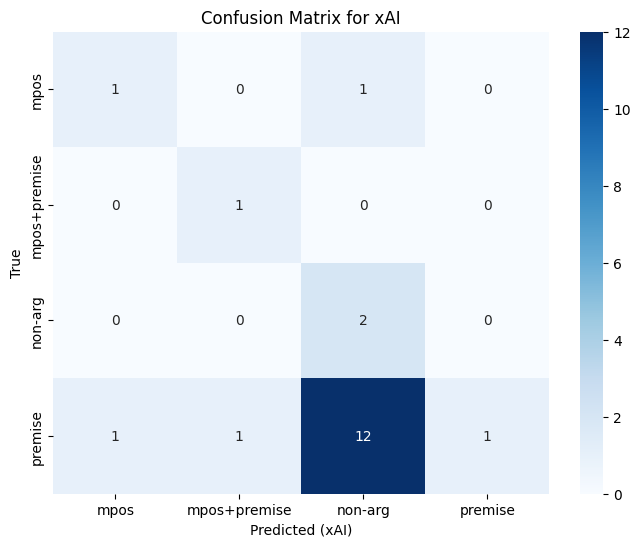


Classification metrics for OpenAI
Accuracy: 0.25 (25.0%)



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,precision,recall,f1-score,support
mpos,0.000000,0.00,0.000000,2.00
mpos+premise,0.000000,0.00,0.000000,1.00
non-arg,0.133333,1.00,0.235294,2.00
premise,0.750000,0.20,0.315789,15.00
accuracy,0.250000,0.25,0.250000,0.25
macro avg,0.220833,0.30,0.137771,20.00
weighted avg,0.575833,0.25,0.260372,20.00


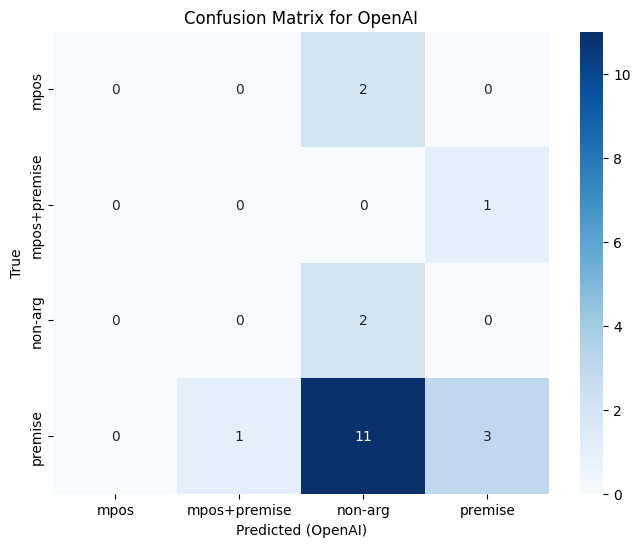

In [ ]:
# !pip install pandas scikit-learn
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

def generate_evaluation_report(df, sample_limit=10):
    # Filter out any rows with missing values in key columns
    df = df.dropna(subset=['code', 'predicted_label_xAI', 'predicted_label_OpenAI',
                           'polarization_score_xAI', 'polarization_score_OpenAI'])

    # Extract unique classes for labels
    classes = sorted(df['code'].unique())

    print("Evaluation Report:")
    print(f"Total Samples: {len(df)}")

    print()
    print("sample Comparison")
    sample_df = df[['content', 'code', 'predicted_label_xAI', 'polarization_score_xAI',
                    'predicted_label_OpenAI', 'polarization_score_OpenAI']].head(sample_limit)
    display(sample_df)
    print()

    # xAI
    print("Classification metrics for xAI")
    y_true = df['code']
    y_pred_xai = df['predicted_label_xAI']
    acc_xai = accuracy_score(y_true, y_pred_xai)
    print(f"Accuracy: {acc_xai:.2f} ({acc_xai*100:.1f}%)")
    print()
    report_xai = classification_report(y_true, y_pred_xai, output_dict=True)
    display(pd.DataFrame(report_xai).transpose())  # As table

    cm_xai = confusion_matrix(y_true, y_pred_xai, labels=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_xai, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted (xAI)')
    plt.ylabel('True')
    plt.title('Confusion Matrix for xAI')
    plt.show()

    # Classification OpenAI
    print()
    print("Classification metrics for OpenAI")
    y_pred_openai = df['predicted_label_OpenAI']
    acc_openai = accuracy_score(y_true, y_pred_openai)
    print(f"Accuracy: {acc_openai:.2f} ({acc_openai*100:.1f}%)")
    print()
    report_openai = classification_report(y_true, y_pred_openai, output_dict=True)
    display(pd.DataFrame(report_openai).transpose())  # As table

    cm_openai = confusion_matrix(y_true, y_pred_openai, labels=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_openai, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted (OpenAI)')
    plt.ylabel('True')
    plt.title('Confusion Matrix for OpenAI')
    plt.show()

# Call the function with your DataFrame
# Replace 'df' with your actual DataFrame name
generate_evaluation_report(df_test_test, 3)  # Adjust sample_limit as needed (e.g., 20 for more samples)

# Optional: Evaluate if you have ground truth labels
#from sklearn.metrics import classification_report
#print(classification_report(df['code'], df['predicted_label']))  # Assuming 'code' is true label

### Validation with data from Swiss voting booklets
Source: https://www.bk.admin.ch/bk/de/home/dokumentation/abstimmungsbuechlein.html

(Bundeskanzlei angefragt für Rohdaten)
to be continued...

In [ ]:
!pip install pdfplumber

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 25.8 MB/s eta 0:00:00


In [ ]:
import requests, re
import pdfplumber
import pandas as pd
from bs4 import BeautifulSoup

In [ ]:
BASE_URL = "https://www.bk.admin.ch"
TARGET_URL = BASE_URL + "/bk/de/home/dokumentation/abstimmungsbuechlein.html"

def find_pdf_links():
    resp = requests.get(TARGET_URL)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")
    links = []
    for a in soup.select("a[href$='.pdf']"):
        text = a.get_text(strip=True)
        if "Erläuterungen des Bundesrates" in text:
            href = a['href']
            url = href if href.startswith("http") else BASE_URL + href
            links.append((text, url))
    return links

def download_pdf(url, filename):
    r = requests.get(url)
    r.raise_for_status()
    with open(filename, "wb") as f:
        f.write(r.content)

def extract_text(pdf_path):
    text = ""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                t = page.extract_text()
                if t:
                    text += t + "\n"
    except Exception as e:
        print(f"Error reading {pdf_path}: {e}")
    return text.strip()

def main(tokenize=False):
    links = find_pdf_links()
    print(f"Gefundene PDFs: {len(links)}")

    records = []
    for title, url in links:
        fname = url.split("/")[-1]
        print(f"\nBearbeite: {title} → {fname}")
        download_pdf(url, fname)

        text = extract_text(fname)
        if not text:
            print("Kein Text extrahierbar – möglicherweise ein Scan als Bild‑PDF oder anderes Problem.")
            continue

        lines = text.splitlines()
        print("Sample output of first lines:")
        for ln in lines[:5]:
            print("  ", ln)

        for line in lines:
            if tokenize:
                tokens = line.split()
                records.append({"text": line, "tokens": tokens})
            else:
                records.append({"text": line})

    df = pd.DataFrame(records)
    print(f"\nDataFrame erstellt mit {len(df)} Zeilen.")
    return df

if __name__ == "__main__":
    df = main(tokenize=False)
    print(df.head(5))
    # Beispiel: df.to_csv("abstimmungs_texts.csv", index=False)

Gefundene PDFs: 138

Bearbeite: Erläuterungen des Bundesrates (09.02.25)(PDF, 576 kB, 08.07.2025) → erlaeuterungen_februar-2025_fr.pdf
Sample output of first lines:
   Volksabstimmung 9. Februar 2025
   Vorlage Volksinitiative
   «Für eine verantwortungsvolle
   Wirtschaft innerhalb der
   planetaren Grenzen (Umwelt-

Bearbeite: Erläuterungen des Bundesrates (24.11.24)(PDF, 1 MB, 07.10.2024) → Erlaeuterungen_November-2024_de%20(2).pdf
Sample output of first lines:
   Volksabstimmung 24. November 2024
   Erste Vorlage Bundesbeschluss über
   den Ausbauschritt 2023
   für die Nationalstrassen
   Zweite Vorlage Änderung des Obligationen-

Bearbeite: Erläuterungen des Bundesrates (22.09.24)(PDF, 2 MB, 07.10.2024) → BAR_Sept_24_de%20(7).pdf
Sample output of first lines:
   Volksabstimmung 22. September 2024
   Erste Vorlage Volksinitiative «Für die Zukunft
   unserer Natur und Landschaft
   (Biodiversitätsinitiative)»
   Zweite Vorlage Reform der beruflichen

Bearbeite: Erläuterungen des Bu

Sample output of first lines:
   01-32_UG_d 10.12.2007 14:40 Uhr Seite 1
   Volksabstimmung vom
   24. Februar 2008
   Erläuterungen des Bundesrates
   1 Volksinitiative

Bearbeite: Erläuterungen des Bundesrates (17.06.2007)(PDF, 1 MB, 27.04.2007) → erlaeuterungen_desbundesrates17062007.pdf
Sample output of first lines:
   01-40_UG_d 11.4.2007 10:26 Uhr Seite 1
   Volksabstimmung vom
   17. Juni 2007
   Erläuterungen des Bundesrates
   Änderung des

Bearbeite: Erläuterungen des Bundesrates (11.03.2007)(PDF, 181 kB, 22.01.2007) → erlaeuterungen_desbundesrates_11032007.pdf
Sample output of first lines:
   01-16_UG_d 5.1.2007 13:03 Uhr Seite 1
   Volksabstimmung vom
   11. März 2007
   Erläuterungen des Bundesrates
   Volksinitiative

Bearbeite: Erläuterungen des Bundesrates (26.11.2006)(PDF, 513 kB, 28.09.2006) → erlaeuterungen_desbundesrates_26112006.pdf
Sample output of first lines:
   Volksabstimmung vom
   26. November 2006
   Erläuterungen des Bundesrates
   1 Bundesgesetz
   über d